In [1]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

In [2]:
tf.disable_v2_behavior()
print(tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
2.2.0-dlenv


## Exploring the data

Let's download MNIST data and examine the shape.

In [3]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

In [4]:
# Get mnist data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale our features between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0 

# Convert labels to categorical one-hot encoding
y_train = tf.keras.utils.to_categorical(y = y_train, num_classes = NCLASSES)
y_test = tf.keras.utils.to_categorical(y = y_test, num_classes = NCLASSES)

print("x_train.shape = {}".format(x_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("x_test.shape = {}".format(x_test.shape))
print("y_test.shape = {}".format(y_test.shape))

x_train.shape = (60000, 28, 28)
y_train.shape = (60000, 10)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000, 10)


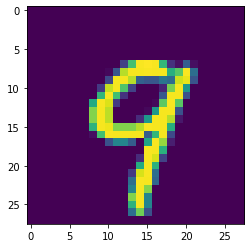

In [5]:
IMGNO = 12
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model.
Let's start with a very simple linear classifier. All our models will have this basic interface -- they will take an image and return probabilities.

In [6]:
# Build Keras Model Using Keras Sequential API
def linear_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = [HEIGHT, WIDTH], name = "image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = NCLASSES, activation = tf.nn.softmax, name = "probabilities"))
    return model

## Write Input Functions

As usual, we need to specify input functions for training, evaluation, and predicition.

In [7]:
# Create training input function
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"image": x_train},
    y = y_train,
    batch_size = 100,
    num_epochs = None,
    shuffle = True,
    queue_capacity = 5000
  )

# Create evaluation input function
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"image": x_test},
    y = y_test,
    batch_size = 100,
    num_epochs = 1,
    shuffle = False,
    queue_capacity = 5000
  )

# Create serving input function for inference
def serving_input_fn():
    placeholders = {"image": tf.placeholder(dtype = tf.float32, shape = [None, HEIGHT, WIDTH])}
    features = placeholders # as-is
    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = placeholders)

## Create train_and_evaluate function

 tf.estimator.train_and_evaluate does distributed training.

In [8]:
def train_and_evaluate(output_dir, hparams):
    # Build Keras model
    model = linear_model()
        
    # Compile Keras model with optimizer, loss function, and eval metrics
    model.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"])
        
    # Convert Keras model to an Estimator
    estimator = tf.keras.estimator.model_to_estimator(
        keras_model = model, 
        model_dir = output_dir)

    # Set estimator's train_spec to use train_input_fn and train for so many steps
    train_spec = tf.estimator.TrainSpec(
        input_fn = train_input_fn,
        max_steps = hparams["train_steps"])

    # Create exporter that uses serving_input_fn to create saved_model for serving
    exporter = tf.estimator.LatestExporter(
        name = "exporter", 
        serving_input_receiver_fn = serving_input_fn)

    # Set estimator's eval_spec to use eval_input_fn and export saved_model
    eval_spec = tf.estimator.EvalSpec(
        input_fn = eval_input_fn,
        steps = None,
        exporters = exporter)

    # Run train_and_evaluate loop
    tf.estimator.train_and_evaluate(
        estimator = estimator, 
        train_spec = train_spec, 
        eval_spec = eval_spec)

This is the main() function

In [9]:
OUTDIR = "mnist/learned"
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {"train_steps": 1000, "learning_rate": 0.01}
train_and_evaluate(OUTDIR, hparams)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Using config: {'_model_dir': 'mnist/learned', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeo